In [1]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for working with dates and times
import datetime as dt

# Import TensorFlow and Keras libraries for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Reshape, Flatten, GRU
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import scikit-learn library for various metrics and preprocessing tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Import matplotlib library for creating plots and charts
import matplotlib.pyplot as plt

# Magic command to display plots inline in the Jupyter Notebook
%matplotlib inline

In [2]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [3]:
# Read in the NEM dataset from a CSV file
df=pd.read_csv("../dataset/cleaned_NEM.csv")
df=df.set_index(pd.DatetimeIndex(df['Date'].values))


# Preprocessing Data

---

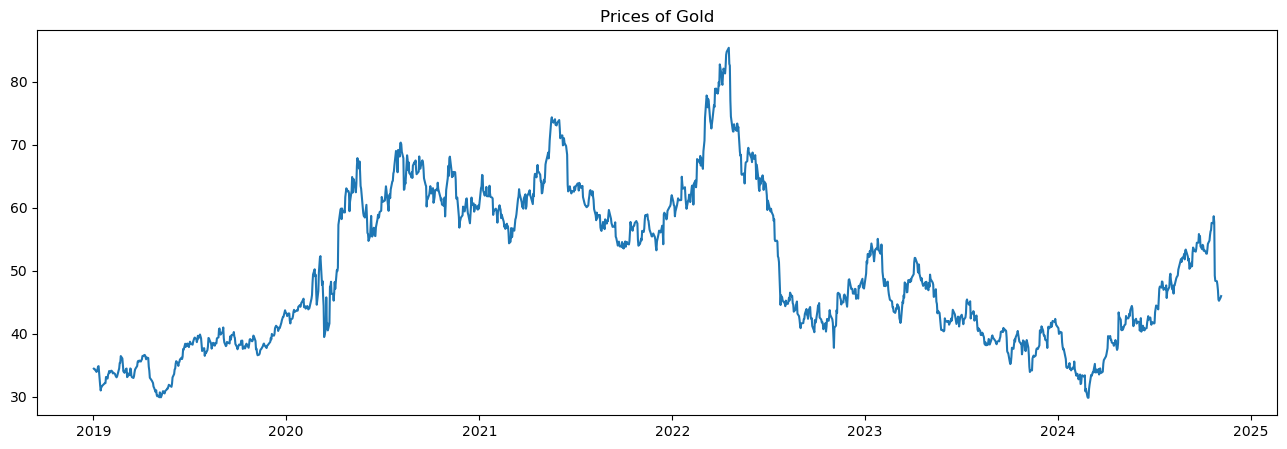

In [4]:

# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Close'])
df1.drop('Date', axis = 1, inplace = True)

# Plot the 'price' column of the 'df' DataFrame
plt.figure(figsize=(16,5))
plt.plot(df1['Close'])
plt.title('Prices of Gold')
plt.show()

# Split dataset (7-2-1)

---



In [5]:
# Create a MinMaxScaler object with a specified range
data = df1.values
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
sc_train = sc.fit_transform(data)

# Split the data
train_size = int(0.7 * len(sc_train))
test_size = int(0.2 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [6]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [7]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [8]:
# Build the model
model = Sequential()

# Add a GRU layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(GRU(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add another GRU layer with 50 units and return_sequences set to True
model.add(GRU(50, return_sequences=True))

# Add a final GRU layer with 50 units
model.add(GRU(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')

# Set the filename to use for saving the model with the correct '.keras' extension
save_model = 'save_model_7_2_1.keras'

# Create a ModelCheckpoint object to save the best model during training
best_model = ModelCheckpoint(
    filepath=save_model,
    monitor='loss',
    verbose=2,
    save_best_only=True,
    mode='auto'
)

# Train the model using the 'fit' method
model.fit(
    x_train,
    y_train,
    epochs=80,
    batch_size=50,
    verbose=2,
    callbacks=[best_model]
)

Epoch 1/80


c:\Users\yashi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.16442, saving model to save_model_7_2_1.keras
21/21 - 4s - 204ms/step - loss: 0.1644
Epoch 2/80

Epoch 2: loss improved from 0.16442 to 0.04429, saving model to save_model_7_2_1.keras
21/21 - 0s - 6ms/step - loss: 0.0443
Epoch 3/80

Epoch 3: loss improved from 0.04429 to 0.02831, saving model to save_model_7_2_1.keras
21/21 - 0s - 6ms/step - loss: 0.0283
Epoch 4/80

Epoch 4: loss improved from 0.02831 to 0.02593, saving model to save_model_7_2_1.keras
21/21 - 0s - 6ms/step - loss: 0.0259
Epoch 5/80

Epoch 5: loss improved from 0.02593 to 0.02522, saving model to save_model_7_2_1.keras
21/21 - 0s - 6ms/step - loss: 0.0252
Epoch 6/80

Epoch 6: loss did not improve from 0.02522
21/21 - 0s - 5ms/step - loss: 0.0255
Epoch 7/80

Epoch 7: loss improved from 0.02522 to 0.02495, saving model to save_model_7_2_1.keras
21/21 - 0s - 7ms/step - loss: 0.0249
Epoch 8/80

Epoch 8: loss improved from 0.02495 to 0.02432, saving model to save_model_7_2_1.keras
21/21 

In [9]:
# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_7_2_1.keras')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step 


In [10]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [11]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [12]:
# Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [13]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 5:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 5)
[0.3074153846309132, 0.2804175432724767, 0.2771777967299105, 0.2861770771827227, 0.29049676203765484]


In [14]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.29627248644828796], [0.3015826642513275], [0.3069623112678528], [0.3124695420265198], [0.3180594742298126], [0.3237502872943878], [0.3295351266860962], [0.3354158401489258], [0.3413940966129303], [0.3474709689617157], [0.3536478281021118], [0.3599259555339813], [0.366306334733963], [0.3727903664112091], [0.3793790340423584], [0.3860734701156616], [0.39287474751472473], [0.3997839391231537], [0.40680190920829773], [0.41392961144447327], [0.4211678206920624], [0.4285174608230591], [0.4359791874885559], [0.44355371594429016], [0.4512413740158081], [0.45904287695884705], [0.4669584035873413], [0.47498831152915955], [0.4831327199935913], [0.49139168858528137]]


In [15]:
# Convert the 'Date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string '%m/%d/%Y'
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 30 days
datelist_future = pd.date_range(datelist_train[-1] + dt.timedelta(days=1), periods=30, freq='1d').tolist()

In [16]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[46.32089923]
 [46.6159327 ]
 [46.91482588]
 [47.2208076 ]
 [47.53138422]
 [47.84756578]
 [48.16897144]
 [48.49570387]
 [48.82785578]
 [49.1654868 ]
 [49.50867308]
 [49.85748582]
 [50.21197967]
 [50.57223246]
 [50.93829882]
 [51.31024167]
 [51.68812062]
 [52.07199529]
 [52.46191369]
 [52.85792881]
 [53.2600837 ]
 [53.66842969]
 [54.0830032 ]
 [54.50384399]
 [54.93097025]
 [55.36442173]
 [55.80420837]
 [56.25035004]
 [56.70285335]
 [57.16172163]]


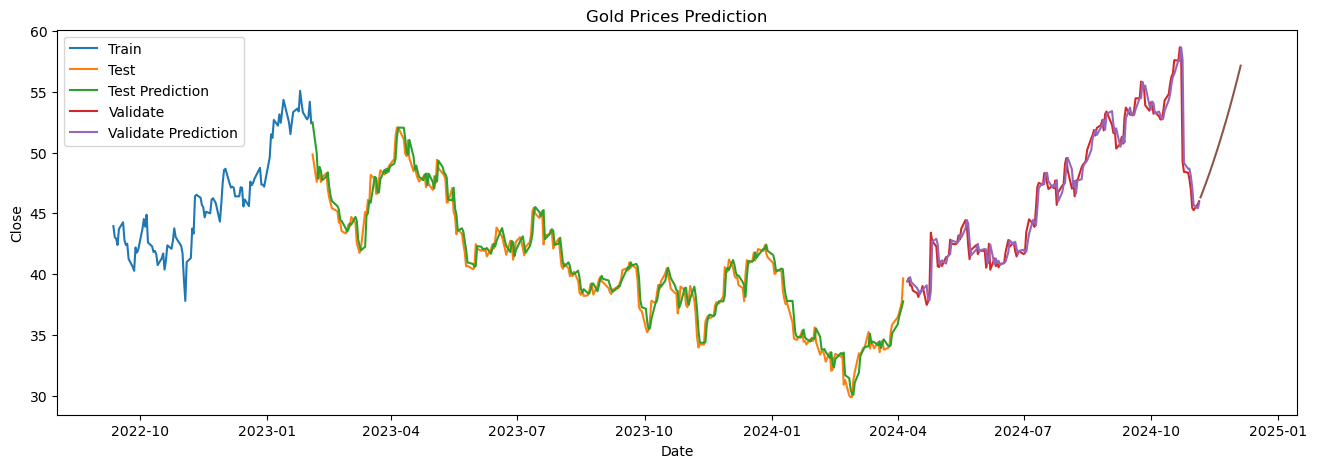

In [17]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['close']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [18]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.6768062682760184
MAPE:  1.6831467699710643
RMSE:  0.8889645723780125

** Validate **
MAE:  0.7000018454923722
MAPE:  1.5032014479402067
RMSE:  1.1272715441688115


# Split dataset (6-3-1)

---



In [19]:
# Split the data
train_size = int(0.6 * len(sc_train))
test_size = int(0.3 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [20]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [21]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [22]:
# Set the filename to use for saving the model with the correct .keras extension
save_model = 'save_model_6_3_1.keras'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])


Epoch 1/80

Epoch 1: loss improved from inf to 0.01645, saving model to save_model_6_3_1.keras
18/18 - 0s - 7ms/step - loss: 0.0165
Epoch 2/80

Epoch 2: loss improved from 0.01645 to 0.01636, saving model to save_model_6_3_1.keras
18/18 - 0s - 7ms/step - loss: 0.0164
Epoch 3/80

Epoch 3: loss improved from 0.01636 to 0.01576, saving model to save_model_6_3_1.keras
18/18 - 0s - 7ms/step - loss: 0.0158
Epoch 4/80

Epoch 4: loss improved from 0.01576 to 0.01572, saving model to save_model_6_3_1.keras
18/18 - 0s - 7ms/step - loss: 0.0157
Epoch 5/80

Epoch 5: loss improved from 0.01572 to 0.01566, saving model to save_model_6_3_1.keras
18/18 - 0s - 7ms/step - loss: 0.0157
Epoch 6/80

Epoch 6: loss did not improve from 0.01566
18/18 - 0s - 5ms/step - loss: 0.0157
Epoch 7/80

Epoch 7: loss did not improve from 0.01566
18/18 - 0s - 5ms/step - loss: 0.0160
Epoch 8/80

Epoch 8: loss improved from 0.01566 to 0.01545, saving model to save_model_6_3_1.keras
18/18 - 0s - 7ms/step - loss: 0.0154
Epoc

In [23]:
# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_6_3_1.keras')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step 


In [24]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [25]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [26]:
# Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [27]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 5:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 5)
[0.3074153846309132, 0.2804175432724767, 0.2771777967299105, 0.2861770771827227, 0.29049676203765484]


In [28]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.29113325476646423], [0.290941447019577], [0.2907291650772095], [0.2907457947731018], [0.2908640205860138], [0.2909965217113495], [0.291120707988739], [0.2912372648715973], [0.2913520336151123], [0.29146748781204224], [0.2915838658809662], [0.2917010188102722], [0.2918187379837036], [0.2919369041919708], [0.292055606842041], [0.2921747863292694], [0.292294442653656], [0.29241469502449036], [0.2925354838371277], [0.2926567494869232], [0.29277852177619934], [0.2929007411003113], [0.29302355647087097], [0.29314690828323364], [0.2932708263397217], [0.29339519143104553], [0.29352012276649475], [0.29364562034606934], [0.2937716543674469], [0.29389819502830505]]


In [29]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[46.03536353]
 [46.0247067 ]
 [46.01291231]
 [46.01383626]
 [46.02040488]
 [46.02776665]
 [46.03466644]
 [46.04114234]
 [46.04751889]
 [46.05393352]
 [46.06039949]
 [46.0669085 ]
 [46.07344898]
 [46.08001429]
 [46.08660941]
 [46.09323103]
 [46.09987913]
 [46.10656035]
 [46.11327138]
 [46.1200089 ]
 [46.12677457]
 [46.13356507]
 [46.14038869]
 [46.14724212]
 [46.15412701]
 [46.16103673]
 [46.16797791]
 [46.17495056]
 [46.18195301]
 [46.18898361]]


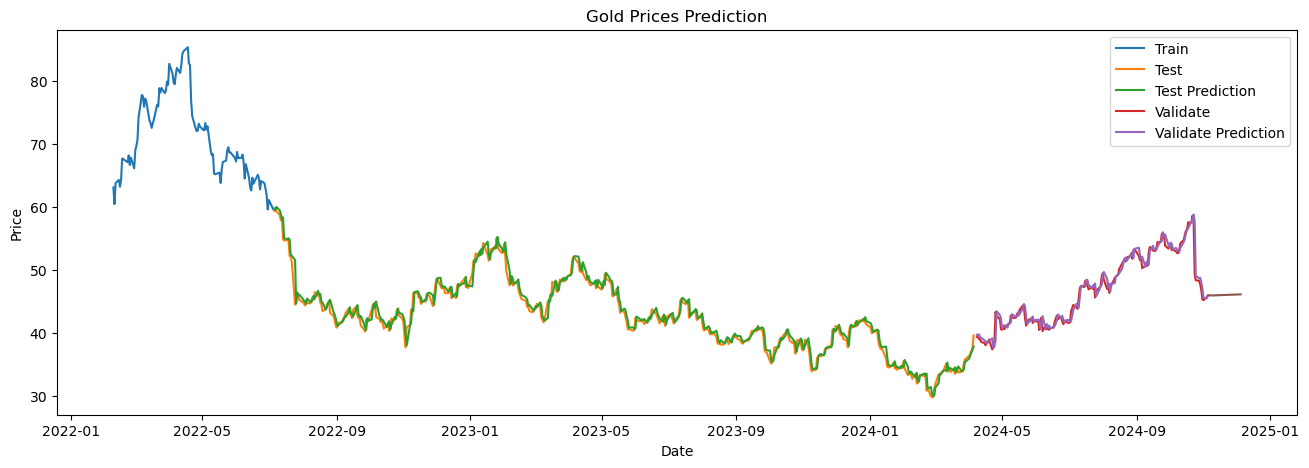

In [30]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [31]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.742553680679951
MAPE:  1.7534014631980233
RMSE:  1.007237502052169

** Validate **
MAE:  0.7082056355680558
MAPE:  1.5292971204948551
RMSE:  1.1362446353300362


# Split dataset (5-3-2)

---



In [32]:
# Split the data
train_size = int(0.5 * len(sc_train))
test_size = int(0.3 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [33]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(5, len(train_data)):
    # Append the last 5 values to the x_train array
    x_train.append(sc_train[i-5:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [34]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [35]:
# Build the model
model = Sequential()

# Add an GRU layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(GRU(50,return_sequences=True,input_shape=(x_train.shape[1],1)))

# Add an GRU layer with 50 units
model.add(GRU(50,return_sequences=True))

# Add an GRU layer with 50 units
model.add(GRU(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_6_3_1.keras'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80


c:\Users\yashi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.18760, saving model to save_model_6_3_1.keras
15/15 - 4s - 257ms/step - loss: 0.1876
Epoch 2/80

Epoch 2: loss improved from 0.18760 to 0.07135, saving model to save_model_6_3_1.keras
15/15 - 0s - 7ms/step - loss: 0.0713
Epoch 3/80

Epoch 3: loss improved from 0.07135 to 0.02985, saving model to save_model_6_3_1.keras
15/15 - 0s - 7ms/step - loss: 0.0299
Epoch 4/80

Epoch 4: loss improved from 0.02985 to 0.02358, saving model to save_model_6_3_1.keras
15/15 - 0s - 8ms/step - loss: 0.0236
Epoch 5/80

Epoch 5: loss improved from 0.02358 to 0.02332, saving model to save_model_6_3_1.keras
15/15 - 0s - 7ms/step - loss: 0.0233
Epoch 6/80

Epoch 6: loss improved from 0.02332 to 0.02319, saving model to save_model_6_3_1.keras
15/15 - 0s - 7ms/step - loss: 0.0232
Epoch 7/80

Epoch 7: loss did not improve from 0.02319
15/15 - 0s - 5ms/step - loss: 0.0236
Epoch 8/80

Epoch 8: loss did not improve from 0.02319
15/15 - 0s - 5ms/step - loss: 0.0240
Epoch 9/80

E

In [36]:
# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_6_3_1.keras')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [37]:
# Preprocess the test data
test = df1[len(train_data)-5:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(5, test.shape[0]):
    x_test.append(sc_test[i-5:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [38]:
# Preprocess the validate data
val = df1[train_size+test_size-5:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(5, val.shape[0]):
    x_val.append(sc_val[i-5:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [39]:
# Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [40]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 5:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 5)
[0.3074153846309132, 0.2804175432724767, 0.2771777967299105, 0.2861770771827227, 0.29049676203765484]


In [41]:
# Initialize variables
lst_output = []
n_steps = 5
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.29139193892478943], [0.2924339175224304], [0.2934960424900055], [0.2946595251560211], [0.2958354949951172], [0.2969972789287567], [0.2981511652469635], [0.2992977499961853], [0.3004382252693176], [0.30157262086868286], [0.3027007579803467], [0.3038225471973419], [0.30493807792663574], [0.3060472011566162], [0.3071499466896057], [0.308246374130249], [0.3093363642692566], [0.3104199767112732], [0.31149715185165405], [0.3125677704811096], [0.31363198161125183], [0.3146897256374359], [0.3157409429550171], [0.3167857229709625], [0.31782400608062744], [0.3188557028770447], [0.3198809027671814], [0.32089948654174805], [0.32191166281700134], [0.32291725277900696]]


In [42]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[46.04973603]
 [46.10762835]
 [46.16664001]
 [46.23128311]
 [46.29661999]
 [46.3611687 ]
 [46.42527862]
 [46.48898287]
 [46.55234767]
 [46.61537469]
 [46.67805398]
 [46.74038059]
 [46.80235948]
 [46.86398236]
 [46.9252509 ]
 [46.9861684 ]
 [47.04672825]
 [47.10693376]
 [47.16678161]
 [47.22626518]
 [47.28539274]
 [47.344161  ]
 [47.40256663]
 [47.46061461]
 [47.51830161]
 [47.57562268]
 [47.63258279]
 [47.6891753 ]
 [47.74541181]
 [47.80128239]]


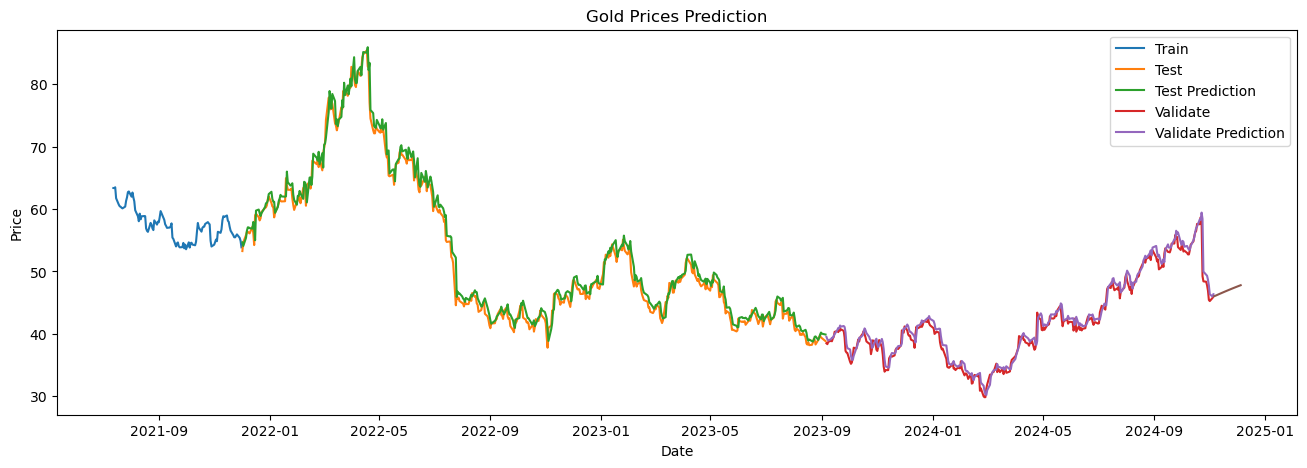

In [43]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Close[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [44]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  1.1075951107562934
MAPE:  2.129715984673345
RMSE:  1.4349278955665652

** Validate **
MAE:  0.8296432688849809
MAPE:  2.029870388327923
RMSE:  1.1675963054760157


# Evaluating model

---

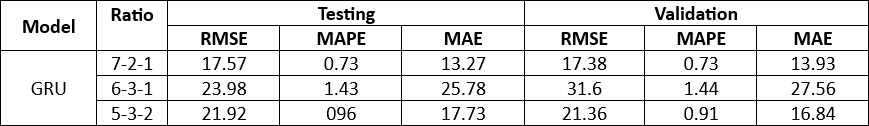
